In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 

In [2]:
# Changing column names
X.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']
y.columns = ['Heating Load', 'Cooling Load']
print(X)

     Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                    0.98         514.5      294.0     110.25             7.0   
1                    0.98         514.5      294.0     110.25             7.0   
2                    0.98         514.5      294.0     110.25             7.0   
3                    0.98         514.5      294.0     110.25             7.0   
4                    0.90         563.5      318.5     122.50             7.0   
..                    ...           ...        ...        ...             ...   
763                  0.64         784.0      343.0     220.50             3.5   
764                  0.62         808.5      367.5     220.50             3.5   
765                  0.62         808.5      367.5     220.50             3.5   
766                  0.62         808.5      367.5     220.50             3.5   
767                  0.62         808.5      367.5     220.50             3.5   

     Orientation  Glazing A

In [3]:
orientation_encoding = pd.get_dummies(X['Orientation'], prefix='Orientation', prefix_sep='=')
glazing_area_encoding = pd.get_dummies(X['Glazing Area Distribution'], prefix='Glazing_Area_Distribution', prefix_sep='=')
X = pd.concat([X.drop('Orientation', axis=1), orientation_encoding], axis=1)
X = pd.concat([X.drop('Glazing Area Distribution', axis=1), glazing_area_encoding], axis=1)
y1 = y['Heating Load'].values
y2 = y['Cooling Load'].values

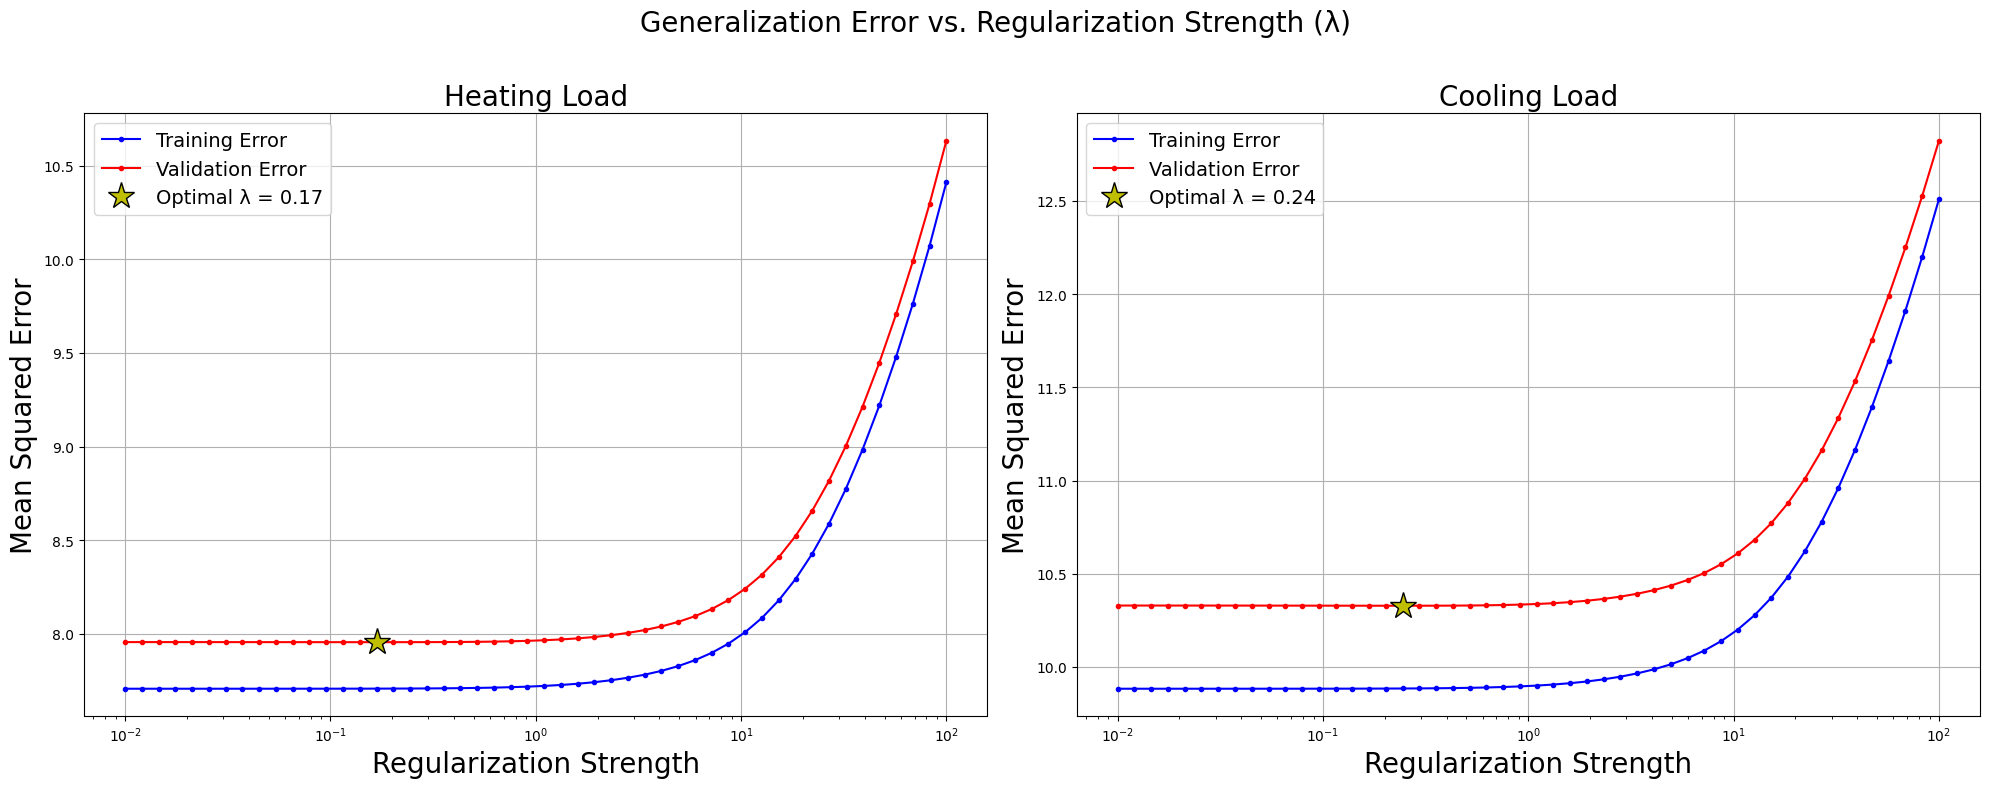

In [4]:
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

np.random.seed(1234)
lambdas = np.logspace(-2, 2, 50)

numerical_features = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area']


def evaluate_regularization(y):
    K = 10
    cv = model_selection.KFold(K, shuffle=True)
    train_errors = np.empty((K, len(lambdas)))
    test_errors = np.empty((K, len(lambdas)))
    for k, (train_index, test_index) in enumerate(cv.split(X)):
        
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            

            mu = np.mean(X_train[numerical_features], axis=0)
            sigma = np.std(X_train[numerical_features], axis=0)


            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            

            X_train_scaled[numerical_features] = (X_train[numerical_features] - mu) / sigma
            X_test_scaled[numerical_features] = (X_test[numerical_features] - mu) / sigma

            for lambda_idx, lambda_val in enumerate(lambdas):

                model = Ridge(alpha=lambda_val)
                model.fit(X_train_scaled, y_train)


                train_errors[k, lambda_idx] = np.mean((y_train - model.predict(X_train_scaled))**2)
                test_errors[k, lambda_idx] = np.mean((y_test - model.predict(X_test_scaled))**2)

    return train_errors, test_errors


hl_train_errors, hl_test_errors = evaluate_regularization(y1)
cl_train_errors, cl_test_errors = evaluate_regularization(y2)

avg_hl_train_errors = np.mean(hl_train_errors, axis=0)
avg_hl_test_errors = np.mean(hl_test_errors, axis=0)

avg_cl_train_errors = np.mean(cl_train_errors, axis=0)
avg_cl_test_errors = np.mean(cl_test_errors, axis=0)

optimal_hyperparameter_hl_idx = np.argmin(avg_hl_test_errors)
optimal_hyperparameter_hl = lambdas[optimal_hyperparameter_hl_idx]

optimal_hyperparameter_cl_idx = np.argmin(avg_cl_test_errors)
optimal_hyperparameter_cl = lambdas[optimal_hyperparameter_cl_idx]
min_error_hl = avg_hl_test_errors[optimal_hyperparameter_hl_idx]

min_error_cl = avg_cl_test_errors[optimal_hyperparameter_cl_idx]




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Generalization Error vs. Regularization Strength (λ)', fontsize=20)


ax1.plot(lambdas, avg_hl_train_errors, 'b.-', label='Training Error')
ax1.plot(lambdas, avg_hl_test_errors, 'r.-', label='Validation Error')
ax1.plot(optimal_hyperparameter_hl, min_error_hl, 'y*', markersize=20, markeredgecolor='k', 
         label=f'Optimal λ = {optimal_hyperparameter_hl:.2f}')
ax1.set_xscale('log')
ax1.set_title('Heating Load', fontsize=20)
ax1.set_xlabel('Regularization Strength', fontsize=20)
ax1.set_ylabel('Mean Squared Error', fontsize=20)
ax1.legend(fontsize=14)
ax1.grid(True)


ax2.plot(lambdas, avg_cl_train_errors, 'b.-', label='Training Error')
ax2.plot(lambdas, avg_cl_test_errors, 'r.-', label='Validation Error')
ax2.plot(optimal_hyperparameter_cl, min_error_cl, 'y*', markersize=20, markeredgecolor='k', 
         label=f'Optimal λ = {optimal_hyperparameter_cl:.2f}')
ax2.set_xscale('log')
ax2.set_title('Cooling Load', fontsize=20)
ax2.set_xlabel('Regularization Strength', fontsize=20)
ax2.set_ylabel('Mean Squared Error', fontsize=20)
ax2.legend(fontsize=14)
ax2.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



/tmp/ipykernel_32276/1268805973.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=15)
/tmp/ipykernel_32276/1268805973.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=15)


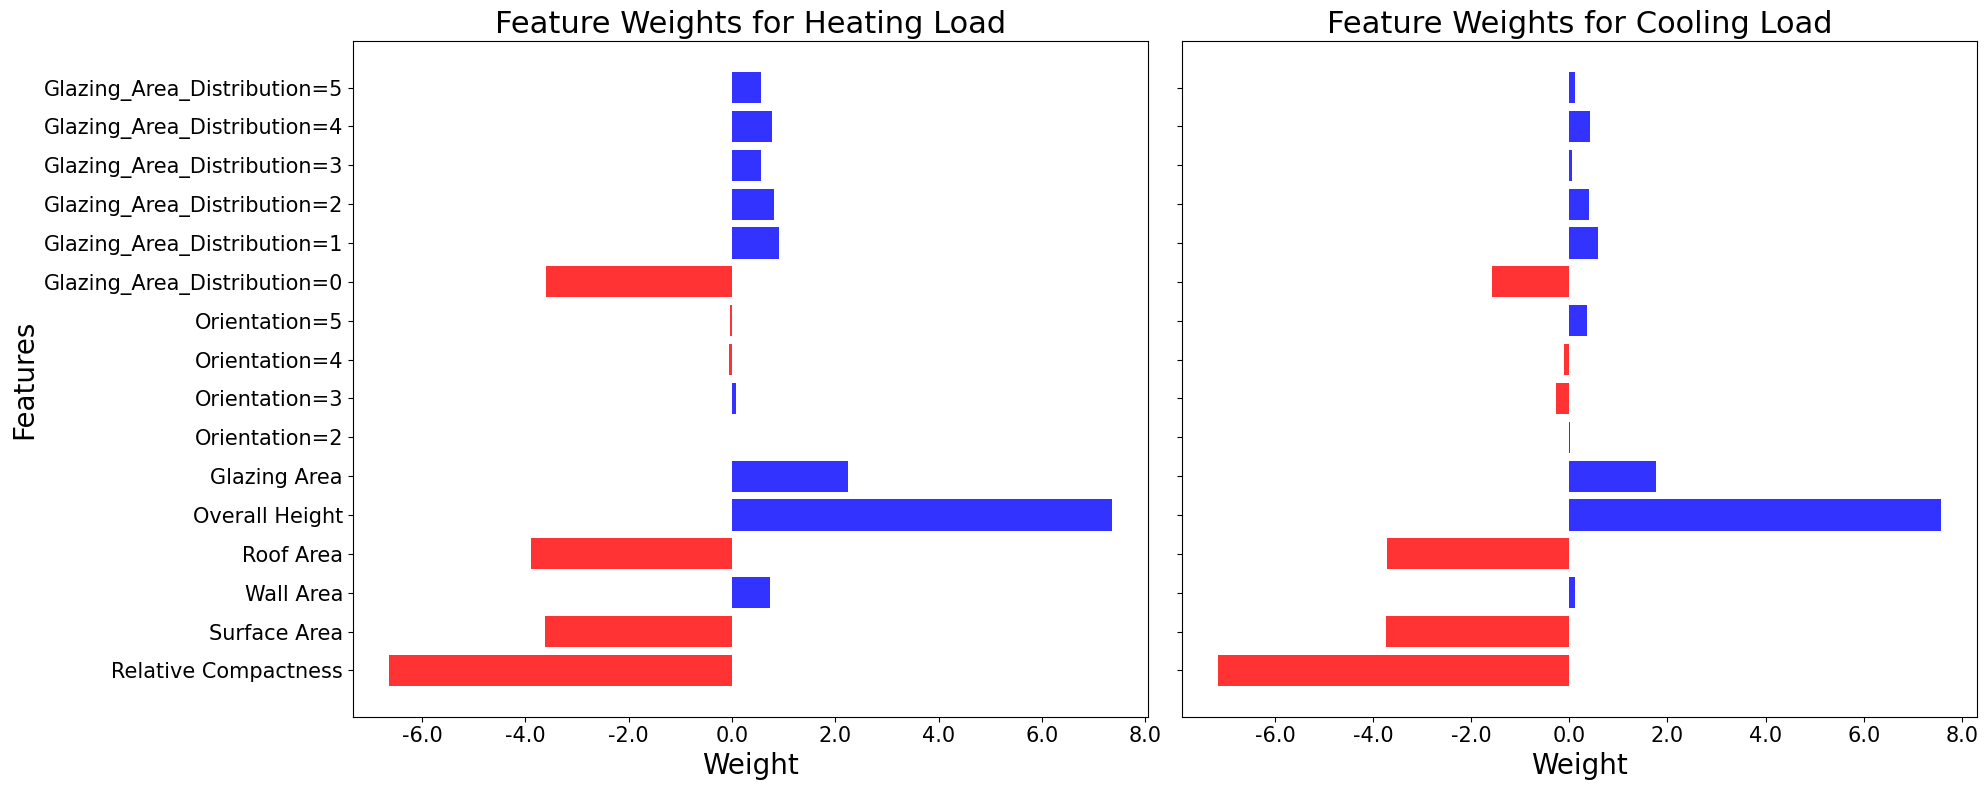

In [5]:
mu = np.mean(X[numerical_features], axis=0)
sigma = np.std(X[numerical_features], axis=0)

X_scaled = X.copy()
X_scaled[numerical_features] = (X[numerical_features] - mu) / sigma
final_model_hl = Ridge(alpha=optimal_hyperparameter_hl)
final_model_hl.fit(X_scaled, y1)
final_model_cl = Ridge(alpha=optimal_hyperparameter_cl)
final_model_cl.fit(X_scaled, y2)
weights_hl = final_model_hl.coef_
weights_cl = final_model_cl.coef_
fig, ax = plt.subplots(1,2,figsize=(20, 8), sharey=True)
y_pos = np.arange(len(X.columns))
ax[0].barh(y_pos, weights_hl, color =['blue' if w>=0 else 'red' for w in weights_hl], alpha=0.8)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(X.columns, fontsize=15)
ax[0].set_title('Feature Weights for Heating Load', fontsize=22)
ax[0].set_xlabel('Weight', fontsize=20)
ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=15)
ax[0].set_ylabel('Features', fontsize=20)
ax[1].barh(y_pos, weights_cl, color =['blue' if w>=0 else 'red' for w in weights_cl], alpha=0.8)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(X.columns, fontsize=15)
ax[1].set_title('Feature Weights for Cooling Load', fontsize=22)
ax[1].set_xlabel('Weight', fontsize=20)
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=15)
plt.tight_layout()
plt.show()

## Regression part b

In [6]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats as st
import torch
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
N, M = X.shape

# Changing column names
X.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']
y.columns = ['Heating Load', 'Cooling Load']

# One-hot encoding
orientation_encoding = pd.get_dummies(X['Orientation'], prefix='Orientation', prefix_sep='=')
glazing_area_encoding = pd.get_dummies(X['Glazing Area Distribution'], prefix='Glazing_Area_Distribution', prefix_sep='=')
X = pd.concat([X.drop('Orientation', axis=1), orientation_encoding], axis=1)
X = pd.concat([X.drop('Glazing Area Distribution', axis=1), glazing_area_encoding], axis=1)
y1 = y['Heating Load'].values
y2 = y['Cooling Load'].values

X = X.astype(np.float32)
y = y.astype(np.float32)

In [7]:
def setup_storage_for_experiment(K_outer, K_inner, num_lambdas, num_units):
    # Setup storage for the optimal hyperparameters found from the inner CV
    optimal_hyperparameters = {
        'lambda': np.empty(K_outer),
        'hidden_units': np.empty(K_outer)
    }

    # Setup storage for model coefficients and errors for each experiment in all inner folds
    # ws_inner = np.empty((M + 1, K_outer, K_inner, num_hyperparams))
    train_errors_inner = {
        'linear': np.empty((K_outer, K_inner, num_lambdas)),
        'ann': np.empty((K_outer, K_inner, num_units))
    }
    test_errors_inner = {
        'linear': np.empty((K_outer, K_inner, num_lambdas)),
        'ann': np.empty((K_outer, K_inner, num_units))
    }

    # Setup storage for model coefficients for each experiment in all outer folds
    # ws_outer = {
    #     'not regularized': np.empty((M + 1, K_outer)),
    #     'regularized': np.empty((M + 1, K_outer))
    # }
    # Setup storage for errors as a dictionary
    errors_outer = {
        'train': {
            'baseline': np.empty((K_outer, 2)), 
            'linear': np.empty((K_outer, 2)),
            'ann': np.empty((K_outer, 2))
        },
        'test': {
            'baseline': np.empty((K_outer, 2)), 
            'linear': np.empty((K_outer, 2)),
            'ann': np.empty((K_outer, 2))
        }
    }
    return optimal_hyperparameters, train_errors_inner, test_errors_inner, errors_outer

In [8]:
class ANNRegressor(torch.nn.Module):
    def __init__(self, num_features, hidden_units, num_outputs=2):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(num_features, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, num_outputs)
        )

    def forward(self, x):
        return self.net(x)


In [9]:
def train_ann(X_train, y_train, X_val, y_val, num_units, epochs=500, lr=0.01):
    model = ANNRegressor(X_train.shape[1], num_units, y_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = torch.nn.MSELoss()

    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).numpy()
    return model, val_preds


In [10]:
def multioutput_mse(y_true, y_pred):
    # y_true and y_pred shape: (N, 2)
    return np.mean(np.sum((y_true - y_pred)**2, axis=1))

In [11]:
K_outer = 10
K_inner = 10
seed = 42

CV_outer = KFold(K_outer, shuffle=True, random_state=seed)
CV_inner = KFold(K_inner, shuffle=True, random_state=seed)

all_true = []
all_pred_ann = []
all_pred_linear = []
all_pred_baseline = []

# lambdas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,]
lambdas = np.logspace(-2, 2, 50)
hidden_units = [16, 32, 64, 128, 256, 512, 750]
numerical_features = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area']

optimal_hyperparameters, train_errors_inner, test_errors_inner, errors_outer = setup_storage_for_experiment(K_outer, K_inner, len(lambdas), len(hidden_units))

for outer_fold_idx, (outer_train_index, outer_test_index) in enumerate(CV_outer.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[outer_train_index, :], X.iloc[outer_test_index, :]
    y_train_outer, y_test_outer = y.iloc[outer_train_index], y.iloc[outer_test_index]
    
    
    for inner_fold_idx, (inner_train_index, inner_test_index) in enumerate(CV_inner.split(X_train_outer, y_train_outer)):
        X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_index, :], X_train_outer.iloc[inner_test_index, :]
        y_train_inner, y_test_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_test_index]
        
        # Calculate the mean and std of inner training loop and standardize datasets
        mu = np.mean(X_train_inner[numerical_features], axis=0)
        sigma = np.std(X_train_inner[numerical_features], axis=0)
            
        X_train_inner[numerical_features] = (X_train_inner[numerical_features] - mu) / sigma
        X_test_inner[numerical_features] = (X_test_inner[numerical_features] - mu) / sigma
        
        # Iterate over lambdas and calculate test errors
        for lambda_idx, regularization_strength in enumerate(lambdas):
            linear_model = Ridge(regularization_strength)
            linear_model.fit(X_train_inner, y_train_inner)
            
            train_errors_inner['linear'][outer_fold_idx, inner_fold_idx, lambda_idx] = multioutput_mse(y_train_inner, linear_model.predict(X_train_inner))
            test_errors_inner['linear'][outer_fold_idx, inner_fold_idx, lambda_idx] = multioutput_mse(y_test_inner, linear_model.predict(X_test_inner))
            
        # Iterate over number of hidden units and calculate test errors
        for unit_idx, num_units in enumerate(hidden_units):
            model, val_pred = train_ann(X_train_inner, y_train_inner, X_test_inner, y_test_inner, num_units=num_units)
            test_errors_inner['ann'][outer_fold_idx, inner_fold_idx, unit_idx] = multioutput_mse(y_test_inner.values, val_pred)

    all_true.append(y_test_outer)
    # Choose optimal hyperparameters for each model
    optimal_lambda = lambdas[np.argmin(np.mean(test_errors_inner['linear'][outer_fold_idx], axis=0))]
    optimal_units = hidden_units[np.argmin(np.mean(test_errors_inner['ann'][outer_fold_idx], axis=0))]
    
    # Store the optimal regularization strength for the current outer fold
    optimal_hyperparameters['lambda'][outer_fold_idx] = optimal_lambda
    optimal_hyperparameters['hidden_units'][outer_fold_idx] = optimal_units

    # Compute the mean and standard deviation of the outer training data split, then standardize the training and test sets

    mu_outer = np.mean(X_train_outer[numerical_features], axis=0)
    sigma_outer = np.std(X_train_outer[numerical_features], axis=0)
    
    X_train_outer[numerical_features] = (X_train_outer[numerical_features] - mu_outer) / sigma_outer
    X_test_outer[numerical_features] = (X_test_outer[numerical_features] - mu_outer) / sigma_outer
    
    # Create and fit models with optimal hyperparameters
    linear_model = Ridge(optimal_lambda)
    linear_model.fit(X_train_outer, y_train_outer)
    
    # Linear model
    train_pred_linear = linear_model.predict(X_train_outer)
    test_pred_linear = linear_model.predict(X_test_outer)

    errors_outer['train']['linear'][outer_fold_idx] = np.mean((y_train_outer.values - train_pred_linear)**2, axis=0)
    errors_outer['test']['linear'][outer_fold_idx] = np.mean((y_test_outer.values - test_pred_linear)**2, axis=0)
    all_pred_linear.append(test_pred_linear)

    # ANN model
    _, test_pred_ann = train_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer, num_units=optimal_units)
    errors_outer['test']['ann'][outer_fold_idx] = np.mean((y_test_outer.values - test_pred_ann)**2, axis=0)
    all_pred_ann.append(test_pred_ann)
    
    # Baseline
    baseline_mean = y_train_outer.mean(axis=0)
    baseline_pred_train = np.tile(baseline_mean, (len(y_train_outer), 1))
    baseline_pred_test = np.tile(baseline_mean, (len(y_test_outer), 1))

    errors_outer['train']['baseline'][outer_fold_idx] = np.mean((y_train_outer.values - baseline_pred_train)**2, axis=0)
    errors_outer['test']['baseline'][outer_fold_idx] = np.mean((y_test_outer.values - baseline_pred_test)**2, axis=0)
    
    all_pred_baseline.append(baseline_pred_test)

table_data = {
    "Outer fold i": np.arange(1, K_outer+1),
    "h* (ANN)": optimal_hyperparameters['hidden_units'],
    "E_test Heating (ANN)": errors_outer['test']['ann'][:, 0],
    "E_test Cooling (ANN)": errors_outer['test']['ann'][:, 1],
    "λ* (Linear)": np.round(optimal_hyperparameters['lambda'], 2),
    "E_test Heating (Linear)": errors_outer['test']['linear'][:, 0],
    "E_test Cooling (Linear)": errors_outer['test']['linear'][:, 1],
    "E_test Heating (Baseline)": errors_outer['test']['baseline'][:, 0],
    "E_test Cooling (Baseline)": errors_outer['test']['baseline'][:, 1]
}

results_table = pd.DataFrame(table_data)

print("\nTwo-level Cross-Validation Results Table:\n")
print(results_table.to_string(index=False))
            
        
        

/tmp/ipykernel_32276/3902270630.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_inner[numerical_features] = (X_train_inner[numerical_features] - mu) / sigma
/tmp/ipykernel_32276/3902270630.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_inner[numerical_features] = (X_test_inner[numerical_features] - mu) / sigma
/tmp/ipykernel_32276/3902270630.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v


Two-level Cross-Validation Results Table:

 Outer fold i  h* (ANN)  E_test Heating (ANN)  E_test Cooling (ANN)  λ* (Linear)  E_test Heating (Linear)  E_test Cooling (Linear)  E_test Heating (Baseline)  E_test Cooling (Baseline)
            1     750.0              1.163257              1.980111         0.24                 9.496743                11.425260                 110.830772                 100.052315
            2     750.0              1.905248              2.950454         0.17                 6.775269                 7.727831                  98.595772                  86.533829
            3     750.0              1.719219              3.382572         0.24                 8.562625                11.380936                  96.137764                  85.676399
            4     750.0              1.703076              3.317925         0.29                 8.591087                 7.551208                 106.682922                  89.546425
            5     750.0        

### Confidence interval calculation

In [12]:
l1_loss = lambda y, y_pred: np.abs(y - y_pred)
l2_loss = lambda y, y_pred: (y - y_pred)**2

def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # Calculate estimated error, z_hat, as the mean loss across all samples
    n_outputs = y_true.shape[1]
    results = {
        'z_hat' : np.empty(n_outputs),
        'CI': np.empty((n_outputs, 2)),
        'p_value':np.empty(n_outputs)
    }
    
    for j in range(n_outputs):
        z_A = loss_fn(y_true[:, j], y_preds_A[:, j])
        z_B = loss_fn(y_true[:, j], y_preds_B[:, j])
        z = z_A - z_B
        z_hat = np.mean(z)
    
        n = len(y_true)
        nu = n - 1  # degrees of freedom

        sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu)))
    
        CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)

        t_stat = -np.abs(np.mean(z)) / st.sem(z)
        p_value = 2 * st.t.cdf(t_stat, df=nu)
        
        results['z_hat'][j] = z_hat
        results['CI'][j] = np.array(CI)
        results['p_value'][j] = p_value

    return results

alpha = 0.05
y_true = np.vstack(all_true)          #
y_linear = np.vstack(all_pred_linear)
y_ann = np.vstack(all_pred_ann)
y_baseline = np.vstack(all_pred_baseline)

results_linear_vs_ann = confidence_interval_comparison(y_true, y_linear, y_ann, loss_fn=l2_loss)
results_linear_vs_baseline = confidence_interval_comparison(y_true, y_linear, y_baseline, loss_fn=l2_loss)
results_ann_vs_baseline = confidence_interval_comparison(y_true, y_ann, y_baseline, loss_fn=l2_loss)

print("Difference between linear regression and ANN")
for i in range (2):
    if (i == 0):
        print("Heating", end=" -> ")
    else:
        print("Cooling", end=" -> ")
        
    print (f"CI: ({results_linear_vs_ann['CI'][i][0]}, {results_linear_vs_ann['CI'][i][1]}), p-value = {results_linear_vs_ann['p_value'][i]}")
    
print("\nDifference between linear regression and baseline")
for i in range (2):
    if (i == 0):
        print("Heating", end=" -> ")
    else:
        print("Cooling", end=" -> ")
        
    print (f"CI: ({results_linear_vs_baseline['CI'][i][0]}, {results_linear_vs_baseline['CI'][i][1]}), p-value = {results_linear_vs_baseline['p_value'][i]}")

print("\nDifference between ANN and baseline")
for i in range (2):
    if (i == 0):
        print("Heating", end=" -> ")
    else:
        print("Cooling", end=" -> ")
        
    print (f"CI: ({results_ann_vs_baseline['CI'][i][0]}, {results_ann_vs_baseline['CI'][i][1]}), p-value = {results_ann_vs_baseline['p_value'][i]}")


Difference between linear regression and ANN
Heating -> CI: (5.522230947566491, 7.308078920292396), p-value = 2.4915242047367415e-40
Cooling -> CI: (6.1890157329605024, 9.016585959239205), p-value = 2.0371155586475025e-24

Difference between linear regression and baseline
Heating -> CI: (-99.88614320486136, -87.82322263986521), p-value = 1.0467771271451622e-134
Cooling -> CI: (-85.59919822081396, -75.05415260926416), p-value = 7.18907203170884e-131

Difference between ANN and baseline
Heating -> CI: (-106.59629111073374, -93.94338174082876), p-value = 4.273320437525565e-138
Cooling -> CI: (-93.84592552131738, -82.01302223258887), p-value = 1.807424917140047e-126


## Classification

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from scipy.stats import binom, beta

In [14]:
# Split at quartiles 0-25%: Class 0 (low), 25-50%: Class 1 (medium), 50-75%: Class 2 (high), 75-100%: Class 3 (very high)

y1 = y['Heating Load']
y_class = pd.qcut(y1, q=4, labels=[0,1,2,3])

y_binary = pd.Series(y_class.astype(int), index=y1.index, name='HeatingClass')

### Model setup:

In [15]:
# Model Setup: Baseline (Majority Class Classifier)

def train_baseline(y_train):
    unique, counts = np.unique(y_train, return_counts=True)
    majority_class = unique[np.argmax(counts)]
    return majority_class

def predict_baseline(majority_class, n_samples):
    return np.full(n_samples, majority_class)

In [16]:
# Model Setup: Logistic Regression with Regularization
def train_logistic_regression(X_train, y_train, lambda_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # scikit-learn uses C = 1/λ (inverse regularization strength)
    C_val = 1.0 / lambda_val if lambda_val > 0 else 1e12
    model = LogisticRegression(
        C=C_val,
        penalty='l2',
        solver='lbfgs',
        max_iter=2000,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    return model, scaler

def predict_logistic_regression(model, scaler, X_test):
    X_test_scaled = scaler.transform(X_test)
    return model.predict(X_test_scaled)


In [17]:
# Model Setup: Artificial Neural Network
def train_ann(X_train, y_train, n_hidden_units):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Train ANN with one hidden layer
    model = MLPClassifier(
        hidden_layer_sizes=(n_hidden_units,),
        max_iter=2000,
        random_state=420,
        validation_fraction=0.1
    )
    model.fit(X_train_scaled, y_train)
    
    return model, scaler

def predict_ann(model, scaler, X_test):
    X_test_scaled = scaler.transform(X_test)
    return model.predict(X_test_scaled)

### Two-level cross-validation


In [18]:
lambda_values = [0.01, 0.1, 0.5, 1, 2, 5]
hidden_units_values = [50, 60, 70, 90, 100]

In [19]:
from sklearn.model_selection import KFold
import numpy as np

K_outer = 10
K_inner = 10
outer_cv = KFold(n_splits=K_outer, shuffle=True, random_state=42)

results = {
    'fold': [],
    'ann_param': [],
    'ann_error': [],
    'lr_lambda': [],
    'lr_error': [],
    'baseline_error': []
}

# Store predictions for statistical analysis
predictions = {
    'y_true': [],        
    'y_pred_ann': [],    
    'y_pred_lr': [],     
    'y_pred_baseline': [] 
}

# Loop through outer folds
fold_idx = 1
for train_idx, test_idx in outer_cv.split(X):
    print(f"Processing outer fold {fold_idx}/{K_outer}...")
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y_binary.iloc[train_idx], y_binary.iloc[test_idx]
    
    # ========== BASELINE MODEL ==========
    majority_class = train_baseline(y_train_outer)
    y_pred_baseline = predict_baseline(majority_class, len(y_test_outer))
    baseline_error = np.sum(y_test_outer != y_pred_baseline) / len(y_test_outer)
    
    # ========== LOGISTIC REGRESSION with Inner CV ==========
    inner_cv = KFold(n_splits=K_inner, shuffle=True, random_state=42)
    best_lambda = None
    best_inner_error = float('inf')
    
    for lambda_val in lambda_values:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_outer):
            X_inner_train = X_train_outer.iloc[inner_train_idx]
            X_inner_val = X_train_outer.iloc[inner_val_idx]
            y_inner_train = y_train_outer.iloc[inner_train_idx]
            y_inner_val = y_train_outer.iloc[inner_val_idx]
            
            # Train and validate
            model, scaler = train_logistic_regression(X_inner_train, y_inner_train, lambda_val)
            y_pred_val = predict_logistic_regression(model, scaler, X_inner_val)
            error = 1 - accuracy_score(y_inner_val, y_pred_val)
            inner_errors.append(error)
        
        avg_error = np.mean(inner_errors)
        if avg_error < best_inner_error:
            best_inner_error = avg_error
            best_lambda = lambda_val
    
    lr_model, lr_scaler = train_logistic_regression(X_train_outer, y_train_outer, best_lambda)
    y_pred_lr = predict_logistic_regression(lr_model, lr_scaler, X_test_outer)
    lr_error = np.sum(y_test_outer != y_pred_lr) / len(y_test_outer)
    
    # ========== ANN with Inner CV ==========
    best_hidden_units = None
    best_inner_error = float('inf')
    
    for n_units in hidden_units_values:
        inner_errors = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_outer):
            print("Inner fold for ANN with hidden units:", n_units)
            X_inner_train = X_train_outer.iloc[inner_train_idx]
            X_inner_val = X_train_outer.iloc[inner_val_idx]
            y_inner_train = y_train_outer.iloc[inner_train_idx]
            y_inner_val = y_train_outer.iloc[inner_val_idx]
            
            model, scaler = train_ann(X_inner_train, y_inner_train, n_units)
            y_pred_val = predict_ann(model, scaler, X_inner_val)
            error = 1 - accuracy_score(y_inner_val, y_pred_val)
            inner_errors.append(error)
        
        avg_error = np.mean(inner_errors)
        if avg_error < best_inner_error:
            best_inner_error = avg_error
            best_hidden_units = n_units
    
    ann_model, ann_scaler = train_ann(X_train_outer, y_train_outer, best_hidden_units)
    y_pred_ann = predict_ann(ann_model, ann_scaler, X_test_outer)
    ann_error = np.sum(y_test_outer != y_pred_ann) / len(y_test_outer)
    
    # Store results
    results['fold'].append(fold_idx)
    results['ann_param'].append(best_hidden_units)
    results['ann_error'].append(ann_error)
    results['lr_lambda'].append(best_lambda)
    results['lr_error'].append(lr_error)
    results['baseline_error'].append(baseline_error)
    
    # Store predictions for statistical analysis
    predictions['y_true'].append(y_test_outer.values)
    predictions['y_pred_ann'].append(y_pred_ann)
    predictions['y_pred_lr'].append(y_pred_lr)
    predictions['y_pred_baseline'].append(y_pred_baseline)

    fold_idx += 1


Processing outer fold 1/10...
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 50
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 60
Inner fold for ANN with hidden units: 70
Inner fold for ANN with hidden units: 70
Inner fold for ANN with hidden units: 70
Inner fold for ANN with hid

### Statistical Analysis

In [21]:
y_true_all = np.concatenate(predictions['y_true'])
y_pred_ann_all = np.concatenate(predictions['y_pred_ann'])
y_pred_lr_all = np.concatenate(predictions['y_pred_lr'])
y_pred_baseline_all = np.concatenate(predictions['y_pred_baseline'])

n_total = len(y_true_all)

def mcnemar_test(y_true, y_pred_A, y_pred_B, model_A_name, model_B_name, alpha=0.05):
    correct_A = (y_pred_A == y_true)
    correct_B = (y_pred_B == y_true)
    
    n11 = np.sum(correct_A & correct_B)      # Both correct
    n12 = np.sum(correct_A & ~correct_B)     # A correct, B wrong
    n21 = np.sum(~correct_A & correct_B)     # A wrong, B correct
    n22 = np.sum(~correct_A & ~correct_B)    # Both wrong
    
    n = len(y_true)
    
    theta_hat = (n12 - n21) / n
    E_theta = theta_hat
    
    N = n12 + n21
    if N < 5:
        print(f"\n Warning: n12 + n21 = {N} < 5")
        print("  Confidence interval may not be reliable.")

    numerator = n**2 * (n + 1) * (E_theta + 1) * (1 - E_theta)
    denominator = n * (n12 + n21) - (n12 - n21)**2
    Q = numerator / denominator
    
    f = ((E_theta + 1) / 2) * (Q - 1)
    
    g = ((1 - E_theta) / 2) * (Q - 1)
        
    theta_L = 2 * beta.ppf(alpha/2, f, g) - 1
        
    theta_U = 2 * beta.ppf(1 - alpha/2, f, g) - 1

    m = min(n12, n21)
    p_value = 2 * binom.cdf(m, N, 0.5)
    
    return {
        'n11': n11, 'n12': n12, 'n21': n21, 'n22': n22,
        'theta_hat': theta_hat,
        'CI': (theta_L, theta_U),
        'p_value': p_value
    }

comparison_results = []

results_ann_lr = mcnemar_test(
    y_true_all, y_pred_ann_all, y_pred_lr_all,
    "ANN", "Logistic Regression"
)

comparison_results.append({
    'Comparison': 'Logistic Regression vs ANN',
    'CI_lower': -results_ann_lr['CI'][1],  # Flip and swap
    'CI_upper': -results_ann_lr['CI'][0],
    'p_value': results_ann_lr['p_value'],
    'theta': -results_ann_lr['theta_hat']
})

results_lr_baseline = mcnemar_test(
    y_true_all, y_pred_lr_all, y_pred_baseline_all,
    "Logistic Regression", "Baseline"
)

comparison_results.append({
    'Comparison': 'Logistic Regression vs Baseline',
    'CI_lower': results_lr_baseline['CI'][0],
    'CI_upper': results_lr_baseline['CI'][1],
    'p_value': results_lr_baseline['p_value'],
    'theta': results_lr_baseline['theta_hat']
})

results_ann_baseline = mcnemar_test(
    y_true_all, y_pred_ann_all, y_pred_baseline_all,
    "ANN", "Baseline"
)

comparison_results.append({
    'Comparison': 'ANN vs Baseline',
    'CI_lower': results_ann_baseline['CI'][0],
    'CI_upper': results_ann_baseline['CI'][1],
    'p_value': results_ann_baseline['p_value'],
    'theta': results_ann_baseline['theta_hat']
})

results_df = pd.DataFrame(comparison_results)

results_df['95% Confidence Interval'] = results_df.apply(
    lambda row: f"({row['CI_lower']:.4f}, {row['CI_upper']:.4f})", 
    axis=1
)

results_df['p-value'] = results_df['p_value'].apply(lambda x: f"{x:.2e}")

final_table = results_df[['Comparison', '95% Confidence Interval', 'p-value']]


### Logistic Regression

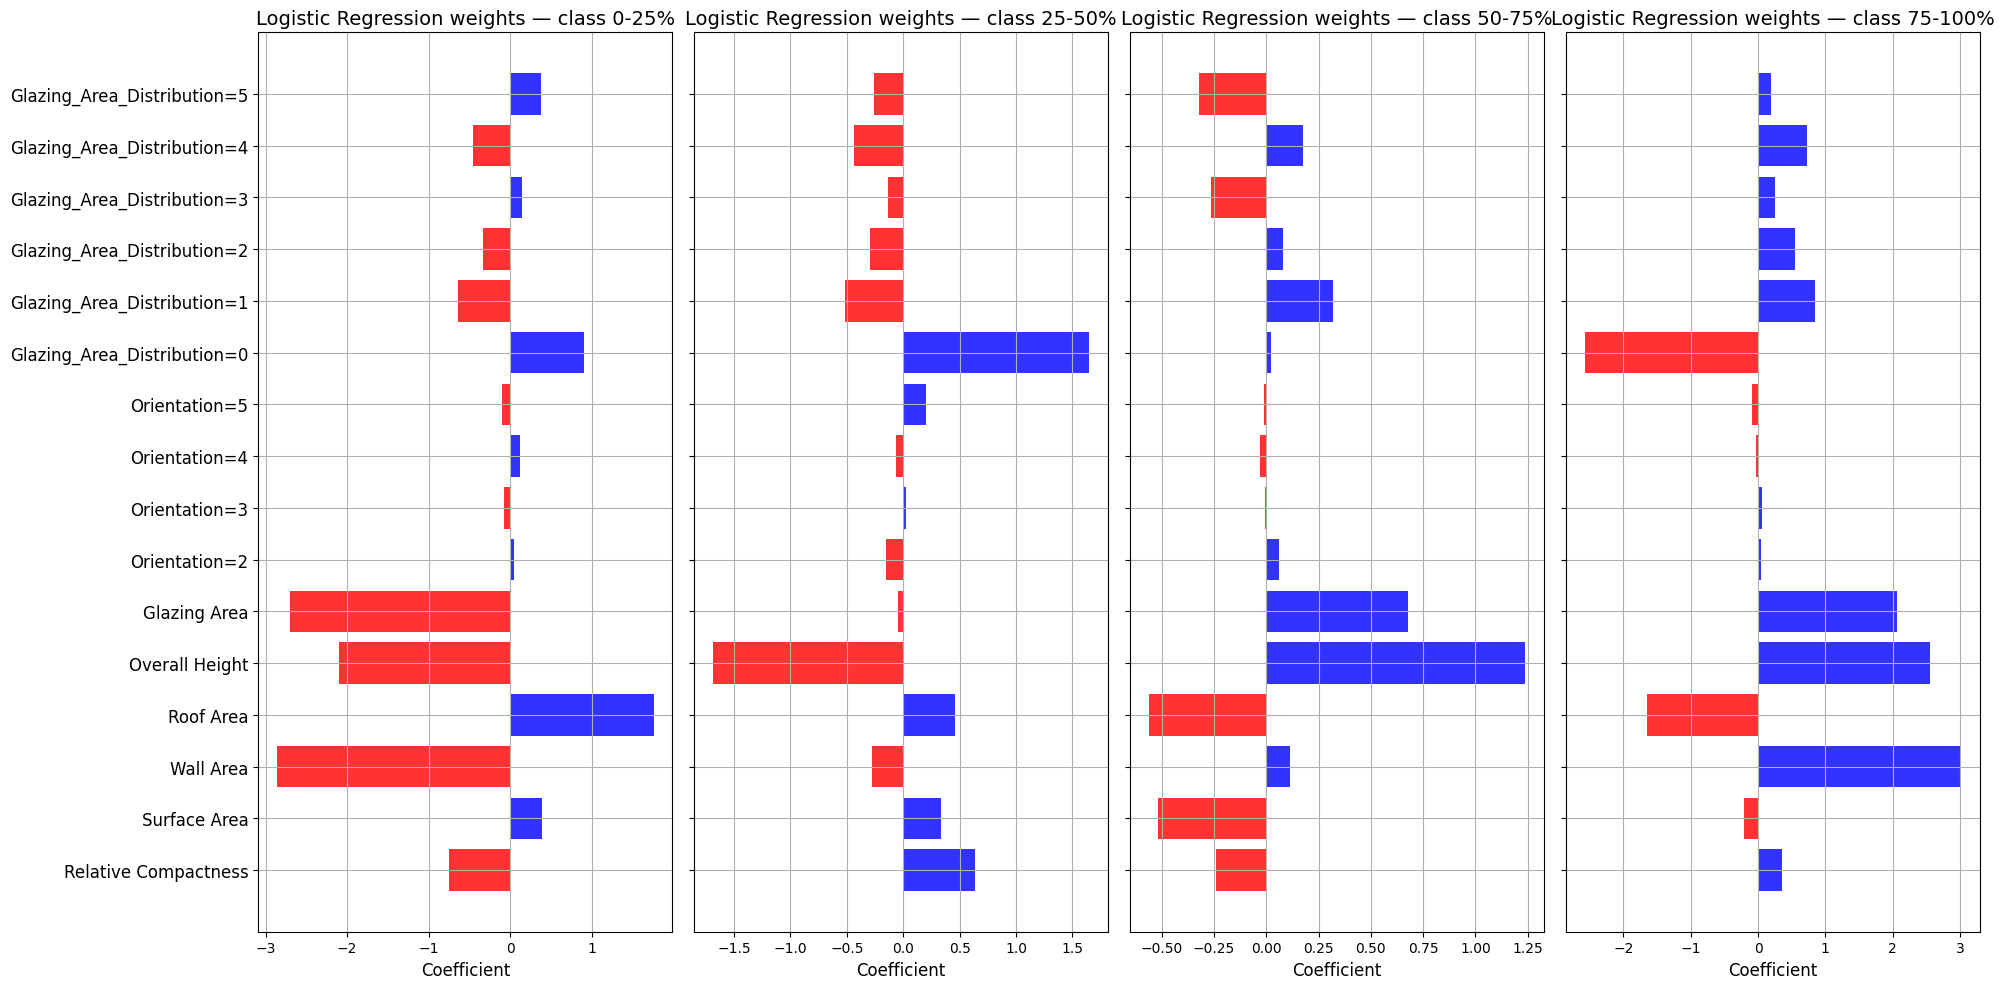

In [22]:
from sklearn.exceptions import ConvergenceWarning
import warnings

mu = np.mean(X[numerical_features], axis=0)
sigma = np.std(X[numerical_features], axis=0)
sigma[sigma == 0] = 1.0

X_scaled = X.copy()
X_scaled[numerical_features] = (X[numerical_features] - mu) / sigma

try:
    final_lambda = float(results_df['LR λ*'].mode()[0])
except Exception:
    final_lambda = 1.0

C_val = 1.0 / final_lambda if final_lambda > 0 else 1e12

# multinomial logistic regression
model_lr = LogisticRegression(
    C=C_val,
    penalty='l2',
    solver='lbfgs',
    max_iter=5000,
    random_state=42
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model_lr.fit(X_scaled, y_binary)

coeffs = model_lr.coef_
n_classes = coeffs.shape[0]

fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 10), sharey=True)
if n_classes == 1:
    axes = [axes]

def GetClassName(i):
    if i == 0: 
        return '0-25%'
    elif i == 1:
        return '25-50%'
    elif i == 2:
        return '50-75%'
    elif i == 3:
        return '75-100%'    

y_pos = np.arange(len(X.columns))
for i, ax in enumerate(axes):
    coef_i = coeffs[i]
    colors = ['blue' if w >= 0 else 'red' for w in coef_i]
    ax.barh(y_pos, coef_i, color=colors, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(X.columns, fontsize=12)
    ax.set_title(f'Logistic Regression weights — class {GetClassName(i)}', fontsize=14)
    ax.set_xlabel('Coefficient', fontsize=12)
    ax.grid(True)


plt.tight_layout()
plt.show()